In [0]:
import platform
import io

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
train_link="https://drive.google.com/open?id=1MHimMDZ7wlYvLsOilWmIqQnxRo4xLn8O"
test_link="https://drive.google.com/open?id=14aEt_3irPQ5MI8ZTFSzj17vwvar00QU0"
label_link="https://drive.google.com/open?id=18xt_fv9r_OpvtGg7f0axAZAgqD8q_sku"

In [0]:
def getFile(link,pkl):
    fluff, id = link.split('=')
    downloaded = drive.CreateFile({'id':id})
    if pkl is True:
        downloaded.GetContentFile('file.pkl')
        file=pd.read_pickle('file.pkl')
        return file
    else:
        downloaded.GetContentFile('label.csv')
        file=pd.read_csv('label.csv')
        return file

In [0]:
train_images=getFile(train_link,True)
train_label=getFile(label_link,False)
test_images=getFile(test_link,True)

In [0]:
# train_images=pd.read_pickle(train_pickle)
# test_images=pd.read_pickle(test_pickle)
# train_labels=pd.read_csv(train_label)

In [0]:
# plt.imshow(train_images[0])

In [0]:
# train_labels.iloc[:10]

In [0]:
class DatasetMNIST(Dataset):
    
    def __init__(self, x, y, transform=None):
        self.transform = transform
        self.data=x
        self.labels=y
        self.train=True
        if y is None:
            self.labels=pd.DataFrame(np.zeros([len(x),2]))
            self.train=False
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        image = self.data[index]
        label=-1
        if self.train is True:
            #label = self.labels.iloc[index.item(),1]
            label = self.labels.iloc[index,1]
        
        if self.transform is not None:
            image = torch.from_numpy(image)
            
        return image, label

In [0]:
transform=transforms.ToTensor()
train_image=DatasetMNIST(train_images,train_label,transform)
train_size = int(0.8 * len(train_image))
train,valid=torch.utils.data.dataset.random_split(train_image,[train_size,len(train_image)-train_size])

In [0]:
BATCH_SIZE=200

train_loader=torch.utils.data.DataLoader(train,batch_size=BATCH_SIZE,shuffle=True)
valid_loader=torch.utils.data.DataLoader(valid,batch_size=BATCH_SIZE,shuffle=False)

In [0]:
class CNN(nn.Module):
    def __init__(self,filter_size=3,padding_size=1,stride_size=1):
        super(CNN,self).__init__()
        self.step1=nn.Sequential(
            nn.Conv2d(1,32,kernel_size=filter_size,padding=padding_size),
            nn.ReLU(),
            nn.Conv2d(32,32,kernel_size=filter_size,padding=padding_size),
            nn.ReLU(),
            nn.MaxPool2d(2),
            #
            nn.Conv2d(32,32,kernel_size=filter_size,padding=padding_size),
            nn.ReLU(),
            nn.Conv2d(32,32,kernel_size=filter_size,padding=padding_size),
            nn.ReLU(),
            nn.MaxPool2d(2),
            #
            nn.Conv2d(32,64,kernel_size=filter_size,padding=padding_size),
            nn.ReLU(),
            nn.Conv2d(64,64,kernel_size=filter_size,padding=padding_size),
            nn.ReLU(),
            nn.Conv2d(64,64,kernel_size=filter_size,padding=padding_size),
            nn.ReLU(),
            nn.MaxPool2d(2),
#             #
#             nn.Conv2d(64,64,kernel_size=filter_size,padding=padding_size),
#             nn.ReLU(),
#             nn.Conv2d(64,64,kernel_size=filter_size,padding=padding_size),
#             nn.ReLU(),
#             nn.Conv2d(64,64,kernel_size=filter_size,padding=padding_size),
#             nn.ReLU(),
#             nn.MaxPool2d(2),
            #
#             nn.Linear(4*4*64,4*4*64),
        )
        self.step2=nn.Sequential(
            nn.Dropout(),
            nn.Linear(16*16*64,4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096,256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256,10),
            nn.Softmax()
        )
    
    def forward(self,x):
        out=self.step1(x)
        out=out.view(out.size(0), -1)
        out=self.step2(out)
        return out

In [0]:
cnn=CNN()
use_gpu=torch.cuda.is_available()
print("GPU Available:{}".format(use_gpu))
if use_gpu:
    cnn.cuda()

GPU Available:True


In [0]:
criterion=nn.CrossEntropyLoss()

In [0]:
def trainCNN(epoch, model,train_loader,optimizer):
    model.train()

    total_loss=0;
    correct=0;

    for i, (image,label) in enumerate(train_loader):

        optimizer.zero_grad()

    #images=image.view(-1,28*28)

        image=image.unsqueeze_(0)
        image=image.permute(1, 0, 2,3)

        if use_gpu:
            image=image.cuda()
            label=label.cuda()

        prediction=model(image)

        loss=criterion(prediction,label)

        loss.backward()

        optimizer.step()

        total_loss+=loss
        pred_classes = prediction.data.max(1,keepdim=True)[1]
        correct += pred_classes.eq(label.data.view_as(pred_classes)).sum().double()

    mean_loss=total_loss/len(train_loader.dataset)
    acc=correct/len(train_loader.dataset)

    print('Train Epoch: {}   Avg_Loss: {:.5f}   Acc: {}/{} ({:.3f}%)'.format(
        epoch, mean_loss, correct, len(train_loader.dataset),
        100. * acc))

    return mean_loss, acc

In [0]:
def evalCNN(model,eval_loader):
  
    model.eval()

    total_loss=0
    correct=0

    for i, (image,label) in enumerate(eval_loader):

        optimizer.zero_grad()

    #images=image.view(-1,28*28)

        image=image.unsqueeze_(0)
        image=image.permute(1, 0, 2,3)

        if use_gpu:
            image=image.cuda()
            label=label.cuda()

        prediction=model(image)

        loss=criterion(prediction,label)

        loss.backward()

        optimizer.step()

        total_loss+=loss

        pred_classes=prediction.data.max(1,keepdim=True)[1]

        correct+=pred_classes.eq(label.data.view_as(pred_classes)).sum().double()

    mean_loss=total_loss/len(eval_loader.dataset)
    acc=correct/len(eval_loader.dataset)

    print('Eval:  Avg_Loss: {:.5f}   Acc: {}/{} ({:.3f}%)'.format(
        mean_loss, correct, len(eval_loader.dataset),
        100. *acc)) 

    return mean_loss, acc

In [0]:
#only evaluation
def evalCNN(model,eval_loader):
  
    model.eval()

    total_loss=0
    correct=0

    for i, (image,label) in enumerate(eval_loader):

        optimizer.zero_grad()

    #images=image.view(-1,28*28)

        image=image.unsqueeze_(0)
        image=image.permute(1, 0, 2, 3)

        if use_gpu:
            image=image.cuda()
            label=label.cuda()

        prediction=model(image)

        #loss=criterion(prediction,label)

        #loss.backward()

        #optimizer.step()

        #total_loss+=loss

        pred_classes=prediction.data.max(1,keepdim=True)[1]

        correct+=pred_classes.eq(label.data.view_as(pred_classes)).sum().double()

    #mean_loss=total_loss/len(eval_loader.dataset)
    acc=correct/len(eval_loader.dataset)

    print('Eval:  Acc: {}/{} ({:.3f}%)'.format(
         correct, len(eval_loader.dataset),
        100. *acc)) 

    return acc

In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [0]:
def save_model(epoch, model, path='./'):
    
    # file name and path 
    filename = path + 'cnn_{}.pt'.format(epoch)
    
    # load the model parameters 
    torch.save(model.state_dict(), filename)
    
    
    return model

In [0]:
optimizer=optim.Adam(cnn.parameters(),lr=0.0001)
# Number of epochs 
numEpochs = 50

# checkpoint frequency 
checkpoint_freq = 10

# path to save the data 
path = './'

# empty lists 
train_losses = []
test_losses = []

train_accuracies = []
test_accuracies = []

# traininng 
for epoch in range(1, numEpochs + 1):
    
    # train() function (see above)
    train_loss, train_acc = trainCNN(epoch, cnn, train_loader, optimizer)
    
    # eval() functionn (see above)
    #test_loss, 
    test_acc = evalCNN(cnn, valid_loader)    
    
    # append lists for plotting and printing 
    train_losses.append(train_loss)    
    #test_losses.append(test_loss)
    
    train_accuracies.append(train_acc)    
    test_accuracies.append(test_acc)
    
    # Checkpoint
    if epoch % checkpoint_freq ==0:
        save_model(epoch, cnn, path)

# Last checkpoint
save_model(numEpochs, cnn, path)
    
print("\n\n\nOptimization ended.\n") 

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Epoch: 1   Avg_Loss: 0.00763   Acc: 37455.0/40000 (93.638%)
Eval:  Acc: 9440.0/10000 (94.400%)
Train Epoch: 2   Avg_Loss: 0.00762   Acc: 37522.0/40000 (93.805%)
Eval:  Acc: 9493.0/10000 (94.930%)
Train Epoch: 3   Avg_Loss: 0.00761   Acc: 37598.0/40000 (93.995%)
Eval:  Acc: 9512.0/10000 (95.120%)
Train Epoch: 4   Avg_Loss: 0.00761   Acc: 37624.0/40000 (94.060%)
Eval:  Acc: 9497.0/10000 (94.970%)
Train Epoch: 5   Avg_Loss: 0.00760   Acc: 37648.0/40000 (94.120%)
Eval:  Acc: 9500.0/10000 (95.000%)
Train Epoch: 6   Avg_Loss: 0.00760   Acc: 37685.0/40000 (94.213%)
Eval:  Acc: 9453.0/10000 (94.530%)
Train Epoch: 7   Avg_Loss: 0.00760   Acc: 37699.0/40000 (94.248%)
Eval:  Acc: 9440.0/10000 (94.400%)
Train Epoch: 8   Avg_Loss: 0.00759   Acc: 37747.0/40000 (94.368%)
Eval:  Acc: 9441.0/10000 (94.410%)
Train Epoch: 9   Avg_Loss: 0.00759   Acc: 37774.0/40000 (94.435%)
Eval:  Acc: 9501.0/10000 (95.010%)
Train Epoch: 10   Avg_Loss: 0.00758   Acc: 37842.0/40000 (94.605%)
Eval:  Acc: 9451.0/10000

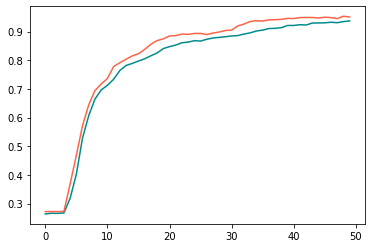

In [0]:
plt.plot(train_accuracies, color="darkcyan", label="train")
plt.plot(test_accuracies, color="tomato",label="validation")
plt.show()

In [0]:
test=DatasetMNIST(test_images,None,transform)

In [0]:
test_loader=torch.utils.data.DataLoader(test,batch_size=BATCH_SIZE,shuffle=False)

In [0]:
cnn.eval()
predictions=[]

for i, (image,label) in enumerate(test_loader):

    image=image.unsqueeze_(0)
    image=image.permute(1, 0, 2,3)

    if use_gpu:
        image=image.cuda()
        label=label.cuda()

    prediction=cnn(image)
    pred_classes=prediction.data.max(1,keepdim=True)[1]
    predictions.append(pred_classes)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [0]:
len(predictions[-2])


200

In [0]:
results=[]
for i in predictions:
    for j in i:
        results.append(j.item())

In [0]:
type(results[0])

int

In [0]:
test_y_pred_df = pd.DataFrame(results, columns=('Label',))
test_y_pred_df.index.name = 'Id'
file=test_y_pred_df.to_csv()

In [0]:
from google.colab import files

with open('vgg_3b.csv','w') as f:
    f.write(file)
    
files.download('vgg_3b.csv')